# **Імпортуємо необхідні модулі**

In [139]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score, GridSearchCV
%matplotlib inline

# **Вантажимо архів з даними**

Так як чомусь не працює зв'язка wget та unzip разом, тому будемо вантажити архів руцями.
Посилання на архів:

In [ ]:
url_share = 'https://drive.google.com/file/d/1IzHsUBubSwUblw1euWHMBMQagfHrqBCf/view?usp=drive_link'
file_id = url_share.split('/')[-2]

URL = f'https://drive.usercontent.google.com/download?id={file_id}&export=download&authuser=0'
print(URL)

https://drive.usercontent.google.com/download?id=1IzHsUBubSwUblw1euWHMBMQagfHrqBCf&export=download&authuser=0


# **Розпаковуємо архів**

In [2]:
FILE_NAME = Path('/content/data.zip')
FOLDER_NAME = Path('/content/data')

# чомусь не працює зв'язка wget та unzip разом, так і не вияснив чому
# тому будемо вантажити архів руцями
# !wget -o $FILE_NAME $URL
!unzip -q -o $FILE_NAME
# !rm $FILE_NAME

# **Обходимо структуру файлів та формуємо єдиний датасет**

In [140]:
def calc_fitures(df: pd.DataFrame):
    s_max = df.max()
    s_mean = df.mean()
    s_min = df.min()
    s_var = df.var()
    s_std = df.std()
    s_median = df.median()

    for col in df.columns:
        df[f'{col}_max'] = s_max[col]
        df[f'{col}_mean'] = s_mean[col]
        df[f'{col}_min'] = s_min[col]
        df[f'{col}_var'] = s_var[col]
        df[f'{col}_std'] = s_std[col]
        df[f'{col}_median'] = s_median[col]
        quartiles = df[col].quantile([0.25, 0.75])
        df[f'{col}_iqr'] = quartiles[0.75] - quartiles[0.25]

    return df

In [141]:
paths_gen = FOLDER_NAME.glob('**/*')

df_train = pd.DataFrame()

for path in paths_gen:
    if path.is_file():
        new_df = pd.read_csv(path)
        new_df = calc_fitures(new_df)
        new_df['activity'] = path.parts[-2]

        df_train = pd.concat([df_train, new_df], axis=0)
        # break

df_train = df_train.reset_index(drop=True)
df_train.head()

,accelerometer_X,accelerometer_Y,accelerometer_Z,accelerometer_X_max,accelerometer_X_mean,accelerometer_X_min,accelerometer_X_var,accelerometer_X_std,accelerometer_X_median,accelerometer_X_iqr,...,accelerometer_Y_median,accelerometer_Y_iqr,accelerometer_Z_max,accelerometer_Z_mean,accelerometer_Z_min,accelerometer_Z_var,accelerometer_Z_std,accelerometer_Z_median,accelerometer_Z_iqr,activity
0,5.640740,-8.566454,1.029507,12.133814,2.483266,-6.320692,17.94827,4.23654,1.359907,6.96593,...,-8.315062,6.65229,10.582372,-1.419762,-14.422671,24.091327,4.908292,-0.80924,4.059369,stairs
1,-0.828394,-0.483629,10.582372,12.133814,2.483266,-6.320692,17.94827,4.23654,1.359907,6.96593,...,-8.315062,6.65229,10.582372,-1.419762,-14.422671,24.091327,4.908292,-0.80924,4.059369,stairs
2,4.491523,-7.393295,-1.589750,12.133814,2.483266,-6.320692,17.94827,4.23654,1.359907,6.96593,...,-8.315062,6.65229,10.582372,-1.419762,-14.422671,24.091327,4.908292,-0.80924,4.059369,stairs
3,4.979940,-10.127473,-14.422671,12.133814,2.483266,-6.320692,17.94827,4.23654,1.359907,6.96593,...,-8.315062,6.65229,10.582372,-1.419762,-14.422671,24.091327,4.908292,-0.80924,4.059369,stairs
4,1.106121,-7.115567,2.240973,12.133814,2.483266,-6.320692,17.94827,4.23654,1.359907,6.96593,...,-8.315062,6.65229,10.582372,-1.419762,-14.422671,24.091327,4.908292,-0.80924,4.059369,stairs


In [142]:
df_train.tail()

,accelerometer_X,accelerometer_Y,accelerometer_Z,accelerometer_X_max,accelerometer_X_mean,accelerometer_X_min,accelerometer_X_var,accelerometer_X_std,accelerometer_X_median,accelerometer_X_iqr,...,accelerometer_Y_median,accelerometer_Y_iqr,accelerometer_Z_max,accelerometer_Z_mean,accelerometer_Z_min,accelerometer_Z_var,accelerometer_Z_std,accelerometer_Z_median,accelerometer_Z_iqr,activity
193855,-6.833051,11.482592,3.639187,15.169662,0.469902,-7.005434,24.858238,4.985804,-0.028731,4.238934,...,-11.453861,7.781156,38.426937,0.201752,-21.188684,101.628814,10.081112,0.756568,5.613206,walking
193856,0.411803,-13.800179,-2.753332,15.169662,0.469902,-7.005434,24.858238,4.985804,-0.028731,4.238934,...,-11.453861,7.781156,38.426937,0.201752,-21.188684,101.628814,10.081112,0.756568,5.613206,walking
193857,0.804452,-19.876663,-16.802507,15.169662,0.469902,-7.005434,24.858238,4.985804,-0.028731,4.238934,...,-11.453861,7.781156,38.426937,0.201752,-21.188684,101.628814,10.081112,0.756568,5.613206,walking
193858,-0.531513,-11.453861,-0.761356,15.169662,0.469902,-7.005434,24.858238,4.985804,-0.028731,4.238934,...,-11.453861,7.781156,38.426937,0.201752,-21.188684,101.628814,10.081112,0.756568,5.613206,walking
193859,-4.510676,-2.729390,4.999093,15.169662,0.469902,-7.005434,24.858238,4.985804,-0.028731,4.238934,...,-11.453861,7.781156,38.426937,0.201752,-21.188684,101.628814,10.081112,0.756568,5.613206,walking


# **Проаналізуємо якість даних датасету**

In [143]:
df_train.shape

(193860, 25)

In [144]:
df_train.isnull().sum()

accelerometer_X           0
accelerometer_Y           0
accelerometer_Z           0
accelerometer_X_max       0
accelerometer_X_mean      0
accelerometer_X_min       0
accelerometer_X_var       0
accelerometer_X_std       0
accelerometer_X_median    0
accelerometer_X_iqr       0
accelerometer_Y_max       0
accelerometer_Y_mean      0
accelerometer_Y_min       0
accelerometer_Y_var       0
accelerometer_Y_std       0
accelerometer_Y_median    0
accelerometer_Y_iqr       0
accelerometer_Z_max       0
accelerometer_Z_mean      0
accelerometer_Z_min       0
accelerometer_Z_var       0
accelerometer_Z_std       0
accelerometer_Z_median    0
accelerometer_Z_iqr       0
activity                  0
dtype: int64

In [145]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193860 entries, 0 to 193859
Data columns (total 25 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   accelerometer_X         193860 non-null  float64
 1   accelerometer_Y         193860 non-null  float64
 2   accelerometer_Z         193860 non-null  float64
 3   accelerometer_X_max     193860 non-null  float64
 4   accelerometer_X_mean    193860 non-null  float64
 5   accelerometer_X_min     193860 non-null  float64
 6   accelerometer_X_var     193860 non-null  float64
 7   accelerometer_X_std     193860 non-null  float64
 8   accelerometer_X_median  193860 non-null  float64
 9   accelerometer_X_iqr     193860 non-null  float64
 10  accelerometer_Y_max     193860 non-null  float64
 11  accelerometer_Y_mean    193860 non-null  float64
 12  accelerometer_Y_min     193860 non-null  float64
 13  accelerometer_Y_var     193860 non-null  float64
 14  accelerometer_Y_std 

# **Проаналізуємо класи (activity)**

In [146]:
df_train['activity'].unique()

array(['stairs', 'idle', 'running', 'walking'], dtype=object)

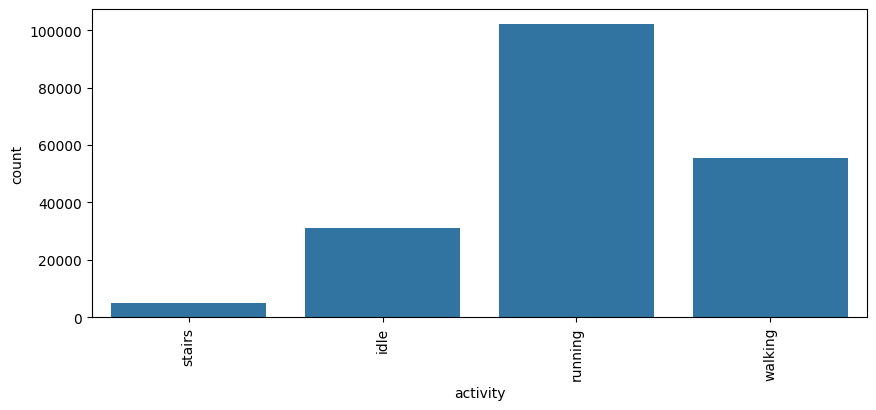

In [147]:
plt.figure(figsize=(10,4))
axis=sns.countplot(x="activity", data=df_train)
plt.xticks(x=df_train['activity'], rotation='vertical')
plt.show()

# **Розділимо датасет по вісях (X,y)**

In [148]:
X = pd.DataFrame(df_train.drop(['activity'], axis=1))
y = df_train.activity.values.astype(object)

In [149]:
X.shape , y.shape

((193860, 24), (193860,))

# **Промаштабуємо фічі**

In [150]:
scaler = StandardScaler()
X = scaler.fit_transform(X)
X[2]

array([ 0.30553486, -0.72082984, -0.47203118, -0.29373504,  0.12187889,
        0.38653118, -0.72127999, -0.52228724,  0.00671291, -0.04843606,
       -1.27302711, -1.43062015, -0.62792539, -0.84827243, -0.68081171,
       -1.20575907, -0.60446429, -0.77741454, -0.88680523, -0.42991216,
       -0.57428945, -0.28565718, -0.60810019, -0.47925097])

# **Розділимо X та y на тренувальні та тестові**

In [151]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [152]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((155088, 24), (38772, 24), (155088,), (38772,))

# **Почнемо тренування (SVC та Random Forest)**

In [153]:
prediction_results = {}

**SVC**

In [154]:
def metrics_score(df: pd.DataFrame, y_test: pd.DataFrame, y_pred: pd.DataFrame, kernel_type: str, param: float):
    df_result = df.copy()

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    df_result.loc[len(df_result.index)] = [kernel_type, param, acc, prec, recall, f1]

    return df_result

In [155]:
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
reg_params = [1., 100., 1000.]

df_result = pd.DataFrame(columns=['kernel', 'param', 'accuracy_score', 'precision_score', 'recall_score', 'f1_score'])

print('Please wait:')

for kernel_type in kernels:
    for param in reg_params:
        print(f'training SVC - {kernel_type} - C={param} ...')

        model = SVC(kernel=kernel_type, C=param)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        df_result = metrics_score(df_result, y_test, y_pred, kernel_type, param)

        prediction_results[f'SVC_{kernel_type}_{int(param)}'] = y_pred

print('Finished!\n')
df_result

Please wait:
training SVC - linear - C=1.0 ...
training SVC - linear - C=100.0 ...
training SVC - linear - C=1000.0 ...
training SVC - poly - C=1.0 ...
training SVC - poly - C=100.0 ...
training SVC - poly - C=1000.0 ...
training SVC - rbf - C=1.0 ...
training SVC - rbf - C=100.0 ...
training SVC - rbf - C=1000.0 ...
training SVC - sigmoid - C=1.0 ...
training SVC - sigmoid - C=100.0 ...
training SVC - sigmoid - C=1000.0 ...
Finished!



,kernel,param,accuracy_score,precision_score,recall_score,f1_score
0,linear,1.0,0.993913,0.993827,0.993913,0.993862
1,linear,100.0,0.994584,0.994543,0.994584,0.994561
2,linear,1000.0,0.994481,0.994447,0.994481,0.994463
3,poly,1.0,0.998710,0.998706,0.998710,0.998700
4,poly,100.0,1.000000,1.000000,1.000000,1.000000
5,poly,1000.0,1.000000,1.000000,1.000000,1.000000
6,rbf,1.0,0.999252,0.999253,0.999252,0.999247
7,rbf,100.0,0.999974,0.999974,0.999974,0.999974
8,rbf,1000.0,0.999974,0.999974,0.999974,0.999974
9,sigmoid,1.0,0.977613,0.978042,0.977613,0.977821


**RandomForestClassifier**

In [156]:
kernels = ['None',]
n_estimators = [10, 50, 100, 200]

df_result = pd.DataFrame(columns=['kernel', 'param', 'accuracy_score', 'precision_score', 'recall_score', 'f1_score'])

print('Please wait:')

for kernel_type in kernels:
    for estimator in n_estimators:
        print(f'training RFC - {kernel_type} - n_estimators={estimator} ...')

        model = RandomForestClassifier(n_estimators=estimator)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        df_result = metrics_score(df_result, y_test, y_pred, kernel_type, estimator)

        prediction_results[f'RFC_{kernel_type}_{int(estimator)}'] = y_pred

print('Finished!\n')
df_result

Please wait:
training RFC - None - n_estimators=10 ...
training RFC - None - n_estimators=50 ...
training RFC - None - n_estimators=100 ...
training RFC - None - n_estimators=200 ...
Finished!



,kernel,param,accuracy_score,precision_score,recall_score,f1_score
0,None,10,1.0,1.0,1.0,1.0
1,None,50,1.0,1.0,1.0,1.0
2,None,100,1.0,1.0,1.0,1.0
3,None,200,1.0,1.0,1.0,1.0


# **Виведемо дані методу classification_report**

In [157]:
for key, value in prediction_results.items():
  print(key)
  print(classification_report(y_test, value))

SVC_linear_1
              precision    recall  f1-score   support

        idle       1.00      1.00      1.00      6231
     running       1.00      1.00      1.00     20491
      stairs       0.89      0.86      0.88       988
     walking       0.99      0.99      0.99     11062

    accuracy                           0.99     38772
   macro avg       0.97      0.96      0.97     38772
weighted avg       0.99      0.99      0.99     38772

SVC_linear_100
              precision    recall  f1-score   support

        idle       1.00      1.00      1.00      6231
     running       1.00      1.00      1.00     20491
      stairs       0.90      0.88      0.89       988
     walking       0.99      0.99      0.99     11062

    accuracy                           0.99     38772
   macro avg       0.97      0.97      0.97     38772
weighted avg       0.99      0.99      0.99     38772

SVC_linear_1000
              precision    recall  f1-score   support

        idle       1.00      1.

# **Висновок**

Мною були задіяні такі моделі SVC та RandomForestClassifier.

Використовуючи модель SVC, було прораховано прогнози по 4-х ядрах ['linear', 'poly', 'rbf', 'sigmoid'], а також, використано 3 коєфіцієнта [1., 100., 1000.].

Використовуючи модель RandomForestClassifier, було використано 4 естімейтора [10, 50, 100, 200].

З наведених звітів та аналітичних таблиць видимо, що найбільш точне прогнозування видали наступні зв'язки:

* Модель SVC з ядром rbf та коєфіцієнтами 100 та 1000
* Модель SVC з ядром poly та коєфіцієнтами 100 та 1000
* Модель RandomForestClassifier

Але, цікаво, що останні дві зв'язки показали результати метрик рівні 1.



